In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import spearmanr
from scipy import stats
import statsmodels.stats.multitest 
from statistics import mean, stdev
from math import sqrt
import pingouin as pg


/opt/homebrew/anaconda3/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.0' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/opt/homebrew/anaconda3/lib/python3.9/site-packages/pandas/core/arrays/masked.py:62: UserWarning: Pandas requires version '1.3.4' or newer of 'bottleneck' (version '1.3.2' currently installed).
  from pandas.core import (


# Load Data and Basic Preprocessing

In [2]:
# load data from data folder 
file_name = "final.csv"
df = pd.read_csv('data/' + file_name, sep=';')
SITUATION_TYPES=["Suc", "Err", "Unc", "Ina", "Sub", "Norm", "Unfor"]
SITUATION_TYPE_LABELS=["Success", "Error", "Uncertainty", "Inability", "Suboptimality", "Norm Violation", "Unforseen Circ."]
PREF_MAPPING = {"Apology": "1", "Why-Expl.":"2", "What-Expl.":"3", "Next-Action":"4", "Ask-for-Help":"5", "Continue":"6"}             
df.head(10)


,StartDate,EndDate,Progress,Duration (in seconds),Finished,RecordedDate,UserLanguage,Consent,AttentionCheckQ1,AttitudesP1,...,instruction_vid,instructions_perc_HHI,instructions_resp_HHI,Create New Field or Choose From Dropdown...,instruction_perc_HRI,social_norm_def,subopt_def,instructions_resp_HRI,FollowUpHHI,FollowUpHRI
0,Start Date,End Date,Progress,Duration (in seconds),Finished,Recorded Date,User Language,I consent to take part in the study and unders...,"Based on the text above, what object have you ...",I can trust persons and organizations related ...,...,instruction_vid,instructions_perc_HHI,instructions_resp_HHI,Create New Field or Choose From Dropdown...,instruction_perc_HRI,social_norm_def,subopt_def,instructions_resp_HRI,FollowUpHHI,FollowUpHRI
1,"{""ImportId"":""startDate"",""timeZone"":""America/De...","{""ImportId"":""endDate"",""timeZone"":""America/Denv...","{""ImportId"":""progress""}","{""ImportId"":""duration""}","{""ImportId"":""finished""}","{""ImportId"":""recordedDate"",""timeZone"":""America...","{""ImportId"":""userLanguage""}","{""ImportId"":""QID31""}","{""ImportId"":""QID87""}","{""ImportId"":""QID1""}",...,"{""ImportId"":""instruction_vid""}","{""ImportId"":""instructions_perc_HHI""}","{""ImportId"":""instructions_resp_HHI""}","{""ImportId"":""Create New Field or Choose From D...","{""ImportId"":""instruction_perc_HRI""}","{""ImportId"":""social_norm_def""}","{""ImportId"":""subopt_def""}","{""ImportId"":""instructions_resp_HRI""}","{""ImportId"":""FollowUpHHI""}","{""ImportId"":""FollowUpHRI""}"
2,2023-09-15 08:23:56,2023-09-15 08:38:27,100,870,TRUE,2023-09-15 08:38:28,EN,Yes,Apple,4,...,Watch the video to be able to answer the quest...,"Given the video above, rate the following stat...","Given the video above, what should the person ...",NaN,"Given the video above, rate the following stat...",Note: Social norm violation refers to socially...,Suboptimal behavior refers to actions that cou...,"Given the video above, what should the robot d...",[Optional] Are there any follow-up actions—not...,[Optional] Are there any follow-up actions—not...
3,2023-09-15 08:29:25,2023-09-15 08:43:39,100,853,TRUE,2023-09-15 08:43:40,EN,Yes,Apple,4,...,Watch the video to be able to answer the quest...,"Given the video above, rate the following stat...","Given the video above, what should the person ...",NaN,"Given the video above, rate the following stat...",Note: Social norm violation refers to socially...,Suboptimal behavior refers to actions that cou...,"Given the video above, what should the robot d...",[Optional] Are there any follow-up actions—not...,[Optional] Are there any follow-up actions—not...
4,2023-09-15 08:33:18,2023-09-15 08:47:04,100,825,TRUE,2023-09-15 08:47:05,EN,Yes,Apple,6,...,Watch the video to be able to answer the quest...,"Given the video above, rate the following stat...","Given the video above, what should the person ...",NaN,"Given the video above, rate the following stat...",Note: Social norm violation refers to socially...,Suboptimal behavior refers to actions that cou...,"Given the video above, what should the robot d...",[Optional] Are there any follow-up actions—not...,[Optional] Are there any follow-up actions—not...
5,2023-09-15 08:25:18,2023-09-15 08:49:27,100,1448,TRUE,2023-09-15 08:49:27,EN,Yes,Apple,4,...,Watch the video to be able to answer the quest...,"Given the video above, rate the following stat...","Given the video above, what should the person ...",NaN,"Given the video above, rate the following stat...",Note: Social norm violation refers to socially...,Suboptimal behavior refers to actions that cou...,"Given the video above, what should the robot d...",[Optional] Are there any follow-up actions—not...,[Optional] Are there any follow-up actions—not...
6,2023-09-15 09:04:57,2023-09-15 09:17:12,100,734,TRUE,2023-09-15 09:17:13,EN,Yes,Apple,6,...,Watch the video to be able to answer the quest...,"Given the video above, rate the following stat...","Given the video above, wh

In [3]:
# remove where "EndDate" == 2023-08-21 05:13:27 or 2023-08-21 10:17:48
# these were participant with non-final versions of the questionnaire
if file_name=="prelim.csv":
    df = df[df.EndDate != "2023-08-21 05:13:27"]
    df = df[df.EndDate != "2023-08-21 10:17:48"]


In [4]:
# remap all '1 ("Completly agree")' to '1',etc.
df = df.replace(to_replace="1 (Completely Disagree)", value="1")
df = df.replace(to_replace="5 (Completely Agree)", value="5")
df = df.replace(to_replace="7 (Completely Agree)", value="7")
df = df.replace(to_replace="7 (a lot of experience)", value="7")
df = df.replace(to_replace="1 (no experience)", value="1")


In [5]:
# convert the columns that are still string to float values
df = df.apply(pd.to_numeric, errors='ignore')

# Remove Invalid Data Points

In [6]:
# remove first two rows as they are meta data
df = df.iloc[2:]

In [7]:
# remove all participants that failed the attentio checks 
len_before = len(df)
df = df[df["AttentionCheckQ1"] == "Apple"] 
df = df[df["Attention Check 2"] == "1"]
len_after = len(df)
print("Removed {} participants that failed one of the first two attention checks".format(len_before - len_after))

# ResponsePref_Suc_G_6 needs to be 5
df = df[df["ResponsePref_Unc_P_7"] == "5"]
df = df[df["ResponsePref_Suc_J_7"] == "5"]
df = df[df["ResponsePref_Ina_G_7"] == "5"]
df = df[df["ResponsePref_Sub_M_7"] == "5"]
len_after_2 = len(df)

# video attention checks
if file_name!="prelim.csv":
    df = df[df["Attention_Vid_G"] == "Bringing an object"] 
    df = df[df["Attention_Vid_1"] == "Counting cans"]

len_after_3 = len(df)

print("Removed {} participants that failed one of the last two attention checks".format(len_after - len_after_2))
print("Removed {} participants that failed one of the last two attention checks".format(len_after_2 - len_after_3))


# 

Removed 8 participants that failed one of the first two attention checks
Removed 1 participants that failed one of the last two attention checks
Removed 0 participants that failed one of the last two attention checks


# Reliability

In [9]:
# convert the columns that are still string to float values
df = df.apply(pd.to_numeric, errors='ignore')
def get_response_pref_ratings(situtaion_type): 
    print(situtaion_type)
    pref_columns=df.filter(regex='^'+situtaion_type).columns
    print(pref_columns)
    pref_dict = {}
    for key in PREF_MAPPING:
        pref_dict[key] = []
    for key in PREF_MAPPING:
        print(key, PREF_MAPPING[key])
        pref_c = [col for col in pref_columns if col.endswith(PREF_MAPPING[key])]
        #for col in pref_c:                                                         # this version adds 1 rating per video, i.e., multiple per user
            #pref_dict[key] += df[col].tolist()
        # instead of individual ratings, we take the average per row
        pref_dict[key] += df[pref_c].mean(axis=1).tolist()
        print(key+" Rating: ", sum(pref_dict[key])/len(pref_dict[key]))
    return pref_dict


SITUATION_TYPES_DETAILED=['Suc_T', 'Suc_G', 'Suc_J', 'Suc_V', 'Err_G', 'Err_S', 'Unc_L', 'Unc_P', 'Ina_G', 'Ina_B', 'Sub_G', 'Sub_M', 'Norm_C', 'Norm_M', 'Unfor_P', 'Unfor_O']
prefs_by_situation_detailed = {}
for sit in SITUATION_TYPES_DETAILED:
    res = get_response_pref_ratings("ResponsePref_"+sit)
    prefs_by_situation_detailed[sit] = res
print(prefs_by_situation_detailed["Unfor_O"])

ResponsePref_Suc_T
Index(['ResponsePref_Suc_T_1', 'ResponsePref_Suc_T_2', 'ResponsePref_Suc_T_3',
       'ResponsePref_Suc_T_4', 'ResponsePref_Suc_T_5', 'ResponsePref_Suc_T_6'],
      dtype='object')
Apology 1
Apology Rating:  1.0913978494623655
Why-Expl. 2
Why-Expl. Rating:  1.3064516129032258
What-Expl. 3
What-Expl. Rating:  1.467741935483871
Next-Action 4
Next-Action Rating:  1.543010752688172
Ask-for-Help 5
Ask-for-Help Rating:  1.1989247311827957
Continue 6
Continue Rating:  3.7311827956989245
ResponsePref_Suc_G
Index(['ResponsePref_Suc_G_1', 'ResponsePref_Suc_G_2', 'ResponsePref_Suc_G_3',
       'ResponsePref_Suc_G_4', 'ResponsePref_Suc_G_5', 'ResponsePref_Suc_G_6'],
      dtype='object')
Apology 1
Apology Rating:  1.2741935483870968
Why-Expl. 2
Why-Expl. Rating:  1.5591397849462365
What-Expl. 3
What-Expl. Rating:  1.7956989247311828
Next-Action 4
Next-Action Rating:  2.010752688172043
Ask-for-Help 5
Ask-for-Help Rating:  1.39247311827957
Continue 6
Continue Rating:  3.5860215053

In [10]:
# compute internal reliability for each situation type
def compute_internal_reliability(situation_type, situation_type2, situation_type3=None, situation_type4=None):
    alphas = []
    for key in situation_type:
        item1_scores=situation_type[key]
        item2_scores=situation_type2[key]
        if situation_type3 != None:
            item3_scores = situation_type3[key]
            item4_scores = situation_type4[key]
            df_rel = pd.DataFrame({'Item1': item1_scores, 'Item2': item2_scores, 'Item3': item3_scores, 'Item4': item4_scores})
        else:
            df_rel = pd.DataFrame({'Item1': item1_scores, 'Item2': item2_scores})
        print(key, round(pg.cronbach_alpha(data=df_rel)[0],3))
        alphas.append(pg.cronbach_alpha(data=df_rel)[0])

    return alphas

#SITUATION_TYPES_DETAILED=['Suc_T', 'Suc_G', 'Suc_J', 'Suc_V', 'Err_G', 'Err_S', 'Unc_L', 'Unc_P', 'Ina_G', 'Ina_B', 'Sub_G', 'Sub_M', 'Norm_C', 'Norm_M', 'Unfor_P', 'Unfor_O']
alphas = []
print("\nUnforseen")
alphas+=compute_internal_reliability(prefs_by_situation_detailed["Unfor_O"], prefs_by_situation_detailed["Unfor_P"])
print("\nNorm")
alphas+=compute_internal_reliability(prefs_by_situation_detailed["Norm_C"], prefs_by_situation_detailed["Norm_M"])
print("\nSuboptimality")
alphas+=compute_internal_reliability(prefs_by_situation_detailed["Sub_G"], prefs_by_situation_detailed["Sub_M"])
print("\nInability")
alphas+=compute_internal_reliability(prefs_by_situation_detailed["Ina_G"], prefs_by_situation_detailed["Ina_B"])
print("\nUncertainty")
alphas+=compute_internal_reliability(prefs_by_situation_detailed["Unc_L"], prefs_by_situation_detailed["Unc_P"])
print("\nError")
alphas+=compute_internal_reliability(prefs_by_situation_detailed["Err_G"], prefs_by_situation_detailed["Err_S"])
print("\nSuccess")
alphas+=compute_internal_reliability(prefs_by_situation_detailed["Suc_T"], prefs_by_situation_detailed["Suc_G"], prefs_by_situation_detailed["Suc_J"], prefs_by_situation_detailed["Suc_V"])

print("\n\n", sum(alphas)/len(alphas))
print(len(alphas))

    


Unforseen
Apology 0.786
Why-Expl. 0.55
What-Expl. 0.641
Next-Action 0.762
Ask-for-Help 0.682
Continue 0.723

Norm
Apology 0.476
Why-Expl. 0.588
What-Expl. 0.576
Next-Action 0.557
Ask-for-Help 0.617
Continue 0.584

Suboptimality
Apology 0.42
Why-Expl. 0.524
What-Expl. 0.71
Next-Action 0.711
Ask-for-Help 0.664
Continue 0.538

Inability
Apology 0.661
Why-Expl. 0.274
What-Expl. 0.581
Next-Action 0.777
Ask-for-Help 0.518
Continue 0.578

Uncertainty
Apology 0.696
Why-Expl. 0.691
What-Expl. 0.721
Next-Action 0.673
Ask-for-Help 0.65
Continue 0.605

Error
Apology 0.683
Why-Expl. 0.541
What-Expl. 0.62
Next-Action 0.562
Ask-for-Help 0.643
Continue 0.597

Success
Apology 0.514
Why-Expl. 0.605
What-Expl. 0.762
Next-Action 0.778
Ask-for-Help 0.815
Continue 0.785


 0.6294272582796501
42


# Analysis

In [11]:
all_p_values = [] # needed for multiple testing correction
p_value_labels = [] 
all_effect_sizes = []

def cohen_d(c0, c1):
    return  (mean(c0) - mean(c1)) / (sqrt((stdev(c0) ** 2 + stdev(c1) ** 2) / 2))

### How do people perceive each video (pre-liminary study)

In [12]:
# convert the columns that are still string to float values
df = df.apply(pd.to_numeric, errors='ignore')

In [13]:
# average time needed
duration = df['Duration (in seconds)'].mean()
print('Average time needed: ', duration, 'seconds')
print('Average time needed: ', duration/60, 'minutes')

for i in df['Duration (in seconds)']:
    print(i/60)

Average time needed:  1258.3118279569892 seconds
Average time needed:  20.971863799283152 minutes
14.5
14.216666666666667
24.133333333333333
12.233333333333333
13.516666666666667
14.733333333333333
14.066666666666666
20.416666666666668
33.85
11.033333333333333
11.15
18.6
21.283333333333335
17.833333333333332
20.8
26.133333333333333
22.433333333333334
28.233333333333334
61.7
11.116666666666667
13.433333333333334
16.533333333333335
13.65
13.65
11.616666666666667
16.2
17.25
19.966666666666665
15.233333333333333
20.833333333333332
14.033333333333333
18.116666666666667
24.5
22.433333333333334
17.666666666666668
47.583333333333336
59.3
18.95
14.366666666666667
10.266666666666667
12.55
10.766666666666667
14.6
14.216666666666667
13.8
12.266666666666667
12.183333333333334
17.616666666666667
10.816666666666666
12.433333333333334
12.616666666666667
11.916666666666666
15.333333333333334
12.033333333333333
13.35
14.733333333333333
13.8
14.316666666666666
14.516666666666667
17.616666666666667
18.833

In [14]:
def get_perception_ratings(situtaion_type, subtypes): 
    print(situtaion_type)
    perception_columns=df.filter(regex='^'+situtaion_type).columns
    print(perception_columns)
    # compute rating for error perception
    perception_columns_1 = [col for col in perception_columns if col.endswith('1')]
    error_rating_list = []
    subtype_ratings = {}
    for s in subtypes:
        subtype_ratings[s] = []
    for col in perception_columns_1:
        error_rating_list += df[col].tolist()
        for s in subtypes:
            if col[-3] == s:
                subtype_ratings[s] += df[col].tolist()
    print("Error Rating: ", sum(error_rating_list)/len(error_rating_list))
    for s in subtypes:
        print("   Error Rating "+s+": ", sum(subtype_ratings[s])/len(subtype_ratings[s]))

    # compute rating for subopt perception
    perception_columns_2 = [col for col in perception_columns if col.endswith('2')]
    subopt_rating_list = []
    subtype_ratings = {}
    for s in subtypes:
        subtype_ratings[s] = []
    for col in perception_columns_2:
        subopt_rating_list += df[col].tolist()
        for s in subtypes:
            if col[-3] == s:
                subtype_ratings[s] += df[col].tolist()
    print("Subopt Rating: ", sum(subopt_rating_list)/len(subopt_rating_list))
    for s in subtypes:
        print("   Subopt Rating "+s+": ", sum(subtype_ratings[s])/len(subtype_ratings[s]))

    # compute rating for social norm perception
    perception_columns_3 = [col for col in perception_columns if col.endswith('3')]
    opt_rating_list = []
    subtype_ratings = {}
    for s in subtypes:
        subtype_ratings[s] = []
    for col in perception_columns_3:
        opt_rating_list += df[col].tolist()
        for s in subtypes:
            if col[-3] == s:
                subtype_ratings[s] += df[col].tolist()
    print("Norm Violation Rating: ", sum(opt_rating_list)/len(opt_rating_list))
    for s in subtypes:
        print("   Norm Violation Rating "+s+": ", sum(subtype_ratings[s])/len(subtype_ratings[s]))

    # compute rating for inability perception
    perception_columns_4 = [col for col in perception_columns if col.endswith('4')]
    inability_rating_list = []
    subtype_ratings = {}
    for s in subtypes:
        subtype_ratings[s] = []
    for col in perception_columns_4:
        inability_rating_list += df[col].tolist()
        for s in subtypes:
            if col[-3] == s:
                subtype_ratings[s] += df[col].tolist()
    print("Inability Rating: ", sum(inability_rating_list)/len(inability_rating_list))
    for s in subtypes:
        print("   Inability Rating "+s+": ", sum(subtype_ratings[s])/len(subtype_ratings[s]))

    # compute rating for uncertainty perception
    perception_columns_5 = [col for col in perception_columns if col.endswith('5')]
    uncertainty_rating_list = []
    subtype_ratings = {}
    for s in subtypes:
        subtype_ratings[s] = []
    for col in perception_columns_5:
        uncertainty_rating_list += df[col].tolist()
        for s in subtypes:
            if col[-3] == s:
                subtype_ratings[s] += df[col].tolist()
    print("Uncertainty Rating: ", sum(uncertainty_rating_list)/len(uncertainty_rating_list))
    for s in subtypes:
        print("   Uncertainty Rating "+s+": ", sum(subtype_ratings[s])/len(subtype_ratings[s]))

    # unexpexted perception
    perception_columns_6 = [col for col in perception_columns if col.endswith('6')]
    unexpected_rating_list = []
    subtype_ratings = {}
    for s in subtypes:
        subtype_ratings[s] = []
    for col in perception_columns_6:
        unexpected_rating_list += df[col].tolist()
        for s in subtypes:
            if col[-3] == s:
                subtype_ratings[s] += df[col].tolist()
    print("Unexpected Rating: ", sum(unexpected_rating_list)/len(unexpected_rating_list))
    for s in subtypes:
        print("   Unexpected Rating "+s+": ", sum(subtype_ratings[s])/len(subtype_ratings[s]))

    # normal perception
    perception_columns_7 = [col for col in perception_columns if col.endswith('7')]
    normal_rating_list = []
    subtype_ratings = {}
    for s in subtypes:
        subtype_ratings[s] = []
    for col in perception_columns_7:
        normal_rating_list += df[col].tolist()
        for s in subtypes:
            if col[-3] == s:
                subtype_ratings[s] += df[col].tolist()
    print("Normal Rating: ", sum(normal_rating_list)/len(normal_rating_list))
    for s in subtypes:
        print("   Normal Rating "+s+": ", sum(subtype_ratings[s])/len(subtype_ratings[s]))
    print()

subtypes=[['T','G','J','V'],["G","S"],["L","P"],["G","B"],["G","M"],["C","M"],["P","O"]]
if file_name=="prelim.csv":
    for sit in SITUATION_TYPES:
        get_perception_ratings("Perception_"+sit, subtypes[SITUATION_TYPES.index(sit)])


### Per situation-type, what is the most wanted response?

In [15]:
prefs_by_situation = {}
for sit in SITUATION_TYPES:
    res = get_response_pref_ratings("ResponsePref_"+sit)
    prefs_by_situation[sit] = res


ResponsePref_Suc
Index(['ResponsePref_Suc_T_1', 'ResponsePref_Suc_T_2', 'ResponsePref_Suc_T_3',
       'ResponsePref_Suc_T_4', 'ResponsePref_Suc_T_5', 'ResponsePref_Suc_T_6',
       'ResponsePref_Suc_G_1', 'ResponsePref_Suc_G_2', 'ResponsePref_Suc_G_3',
       'ResponsePref_Suc_G_4', 'ResponsePref_Suc_G_5', 'ResponsePref_Suc_G_6',
       'ResponsePref_Suc_J_1', 'ResponsePref_Suc_J_2', 'ResponsePref_Suc_J_3',
       'ResponsePref_Suc_J_4', 'ResponsePref_Suc_J_5', 'ResponsePref_Suc_J_6',
       'ResponsePref_Suc_J_7', 'ResponsePref_Suc_V_1', 'ResponsePref_Suc_V_2',
       'ResponsePref_Suc_V_3', 'ResponsePref_Suc_V_4', 'ResponsePref_Suc_V_5',
       'ResponsePref_Suc_V_6'],
      dtype='object')
Apology 1
Apology Rating:  1.1666666666666667
Why-Expl. 2
Why-Expl. Rating:  1.418010752688172
What-Expl. 3
What-Expl. Rating:  1.5631720430107527
Next-Action 4
Next-Action Rating:  1.700268817204301
Ask-for-Help 5
Ask-for-Help Rating:  1.2795698924731183
Continue 6
Continue Rating:  3.6142473118

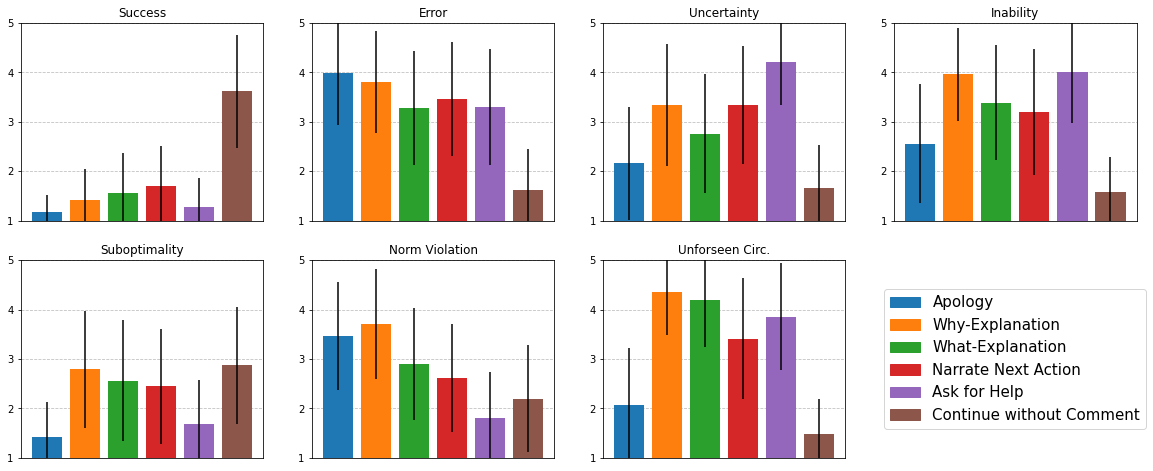

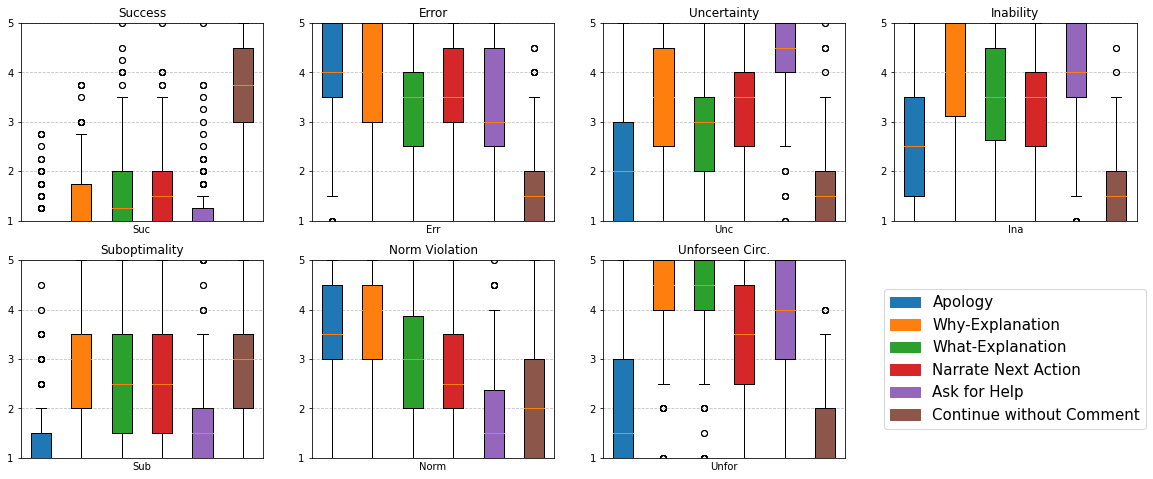

In [16]:
# visualize response pref per situation type as a bar chart (dict with situation type as key and another dict with response pref as key and  rating-list as value)

old_version=False
import matplotlib.patches as mpatches

plt.figure(figsize=(20,8))

for sit in prefs_by_situation:
    if old_version:
        plt.subplot(4, 2, SITUATION_TYPES.index(sit)+1)
    else:
        plt.subplot(2, 4, SITUATION_TYPES.index(sit)+1)
    plt.title(SITUATION_TYPE_LABELS[SITUATION_TYPES.index(sit)])
    plt.ylim(1, 5)
    plt.yticks(range(1, 6), ['1', '2', '3', '4', '5'])
    # add space between subplots
    if old_version: plt.subplots_adjust(hspace=0.6)
    # add y grid
    plt.grid(axis='y')
    # make grid dashed semi-transparent
    plt.gca().set_axisbelow(True)
    plt.gca().yaxis.grid(color='gray', linestyle='dashed', alpha=0.5)
    # beautiful color scheme for 6 colors
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b']
    plt.bar(prefs_by_situation[sit].keys(), [sum(prefs_by_situation[sit][key])/len(prefs_by_situation[sit][key]) for key in prefs_by_situation[sit].keys()], yerr=[np.std(prefs_by_situation[sit][key]) for key in prefs_by_situation[sit].keys()], color=colors[:len(prefs_by_situation[sit].keys())])
    # same plot but updated
    if not old_version: plt.xticks([])
# add a 8th subplot for the legend
if not old_version:
    plt.subplot(2, 4, 8)
    labels=list(prefs_by_situation[sit].keys())
    labels[labels.index('What-Expl.')]='What-Explanation'
    labels[labels.index('Why-Expl.')]='Why-Explanation'
    labels[labels.index('Continue')]='Continue without Comment'
    labels[labels.index('Next-Action')]='Narrate Next Action'
    labels[labels.index('Ask-for-Help')]='Ask for Help'
    plt.legend(handles=[mpatches.Patch(color=colors[i], label=labels[i]) for i in range(len(prefs_by_situation[sit].keys()))], loc='center', prop={'size': 15})
    # hide the subplot
    plt.axis('off')
plt.show()








# visualize response pref per situation type as a bar chart (dict with situation type as key and another dict with response pref as key and  rating-list as value)

old_version=False
import matplotlib.patches as mpatches

plt.figure(figsize=(20,8))
#gs = gridspec.GridSpec(2, 4)
#gs.update(wspace=0.5)
for sit in prefs_by_situation:
    if old_version:
        plt.subplot(4, 2, SITUATION_TYPES.index(sit)+1)
    else:
        plt.subplot(2, 4, SITUATION_TYPES.index(sit)+1)
    plt.title(SITUATION_TYPE_LABELS[SITUATION_TYPES.index(sit)])
    plt.ylim(1, 5)
    plt.yticks(range(1, 6), ['1', '2', '3', '4', '5'])
    # add space between subplots
    if old_version: plt.subplots_adjust(hspace=0.6)
    # add y grid
    plt.grid(axis='y')
    # make grid dashed semi-transparent
    plt.gca().set_axisbelow(True)
    plt.gca().yaxis.grid(color='gray', linestyle='dashed', alpha=0.5)
    # beautiful color scheme for 6 colors
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b']
    #plt.bar(prefs_by_situation[sit].keys(), [sum(prefs_by_situation[sit][key])/len(prefs_by_situation[sit][key]) for key in prefs_by_situation[sit].keys()], yerr=[np.std(prefs_by_situation[sit][key]) for key in prefs_by_situation[sit].keys()], color=colors[:len(prefs_by_situation[sit].keys())])
    # same plot but updated

    if True:
        # Assuming `prefs_by_situation` is a dictionary of dictionaries, with each inner dictionary's values being a list of numbers
        data = [prefs_by_situation[sit][key] for key in prefs_by_situation[sit].keys()]
        labels = list(prefs_by_situation[sit].keys())

        # Create the box plot
        plt.boxplot(data, labels=labels, patch_artist=True, medianprops={'color': 'black'}, whiskerprops={'color': 'black'})

        # Add labels and title if needed
        plt.xlabel(sit)

        # Ensure that the colors list is long enough for the boxes (if desired)
        if len(colors) >= len(labels):
            for patch, color in zip(plt.boxplot(data, labels=labels, patch_artist=True)['boxes'], colors):
                patch.set_facecolor(color)


    if not old_version: plt.xticks([])
# add a 8th subplot for the legend
if not old_version:
    plt.subplot(2, 4, 8)
    labels=list(prefs_by_situation[sit].keys())
    labels[labels.index('What-Expl.')]='What-Explanation'
    labels[labels.index('Why-Expl.')]='Why-Explanation'
    labels[labels.index('Continue')]='Continue without Comment'
    labels[labels.index('Next-Action')]='Narrate Next Action'
    labels[labels.index('Ask-for-Help')]='Ask for Help'
    plt.legend(handles=[mpatches.Patch(color=colors[i], label=labels[i]) for i in range(len(prefs_by_situation[sit].keys()))], loc='center', prop={'size': 15})
    # hide the subplot
    plt.axis('off')
plt.show()






In [17]:
# compute p-values
normality_plots=False

for sit in prefs_by_situation:
    resp_key = list(prefs_by_situation[sit].keys())
    print(sit)
    for resp in resp_key:
        for resp2 in resp_key[resp_key.index(resp)+1:]:
            # Statistical Test for Normality with Shapiro-Wilk Test
            differences = np.array(prefs_by_situation[sit][resp]) - np.array(prefs_by_situation[sit][resp2])
            shapiro_test = stats.shapiro(differences)
            if normality_plots:
                plt.hist(differences, bins=20, alpha=0.7, color='g')
                plt.title('Histogram of Differences')
                plt.xlabel('Difference Score')
                plt.ylabel('Frequency')
                plt.show()
                stats.probplot(differences, dist="norm", plot=plt)
                plt.title('Q-Q Plot of Differences')
                plt.show()
                print(f"Shapiro-Wilk Test Statistic: {shapiro_test[0]}, p-value: {shapiro_test[1]}")
            # conduct test
            if shapiro_test[1] < 0.05: 
                print(f"Shapiro-Wilk Test Statistic: {shapiro_test[0]}, p-value: {shapiro_test[1]}")
                #p_val = stats.wilcoxon(prefs_by_situation[sit][resp], prefs_by_situation[sit][resp2])[1]
                test_res = pg.wilcoxon(prefs_by_situation[sit][resp], prefs_by_situation[sit][resp2])
                p_val = test_res['p-val'].values[0]
                effect_size = test_res["CLES"].values[0]
            else:
                p_val = stats.ttest_rel(prefs_by_situation[sit][resp], prefs_by_situation[sit][resp2])[1]
                effect_size = cohen_d(prefs_by_situation[sit][resp], prefs_by_situation[sit][resp2])
            all_p_values.append(p_val)
            label=sit+"_"+resp+"_"+resp2
            p_value_labels.append(label)
            if p_val < 0.01:
                print("   ", resp, resp2, stats.ttest_rel(prefs_by_situation[sit][resp], prefs_by_situation[sit][resp2]), " ***" )
            elif p_val < 0.05:
                print("   ", resp, resp2, stats.ttest_rel(prefs_by_situation[sit][resp], prefs_by_situation[sit][resp2]), " **" )
            elif p_val < 0.1:
                print("   ", resp, resp2, stats.ttest_rel(prefs_by_situation[sit][resp], prefs_by_situation[sit][resp2]), " *" )
            else:
                print("   ", resp, resp2, stats.ttest_rel(prefs_by_situation[sit][resp], prefs_by_situation[sit][resp2]))
            all_effect_sizes.append(effect_size)


Suc
Shapiro-Wilk Test Statistic: 0.7428971529006958, p-value: 1.0557398802242898e-16
    Apology Why-Expl. Ttest_relResult(statistic=-6.165406664115271, pvalue=4.308198464669952e-09)  ***
Shapiro-Wilk Test Statistic: 0.7955945134162903, p-value: 7.369948123731995e-15
    Apology What-Expl. Ttest_relResult(statistic=-7.343399581414506, pvalue=6.418990211451418e-12)  ***
Shapiro-Wilk Test Statistic: 0.8440362811088562, p-value: 7.762316180451312e-13
    Apology Next-Action Ttest_relResult(statistic=-9.615084380724879, pvalue=5.256484875558879e-18)  ***
Shapiro-Wilk Test Statistic: 0.6053627133369446, p-value: 1.826008795470338e-20
    Apology Ask-for-Help Ttest_relResult(statistic=-3.2314928188893086, pvalue=0.00145782550198266)  ***
Shapiro-Wilk Test Statistic: 0.9321755766868591, p-value: 1.2291739892589248e-07
    Apology Continue Ttest_relResult(statistic=-27.376152264923544, pvalue=5.647956142834509e-67)  ***
Shapiro-Wilk Test Statistic: 0.7914770245552063, p-value: 5.15032454347346

### How does the explanation need differ per situation type?

Suc
2      2.50
3      1.75
5      2.00
6      1.00
7      1.00
       ... 
192    1.00
193    1.00
194    3.00
195    1.75
196    1.25
Length: 186, dtype: float64
Err
2      4.0
3      2.0
5      5.0
6      3.0
7      4.5
      ... 
192    4.0
193    2.5
194    5.0
195    4.5
196    4.5
Length: 186, dtype: float64
Unc
2      4.5
3      3.0
5      5.0
6      1.0
7      3.5
      ... 
192    4.5
193    3.0
194    5.0
195    3.5
196    4.5
Length: 186, dtype: float64
Ina
2      4.5
3      2.5
5      5.0
6      1.0
7      5.0
      ... 
192    4.0
193    1.5
194    5.0
195    4.5
196    5.0
Length: 186, dtype: float64
Sub
2      4.5
3      2.0
5      4.0
6      2.5
7      4.5
      ... 
192    4.0
193    1.0
194    3.0
195    5.0
196    5.0
Length: 186, dtype: float64
Norm
2      5.0
3      1.5
5      5.0
6      2.5
7      4.5
      ... 
192    5.0
193    1.0
194    5.0
195    4.0
196    4.5
Length: 186, dtype: float64
Unfor
2      5.0
3      4.0
5      5.0
6      3.0
7      5.0
      ...

/var/folders/bv/9t03hlvd6jv_vzfmf4gqhkfm0000gn/T/ipykernel_33204/4038455754.py:45: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(sorted_labels)


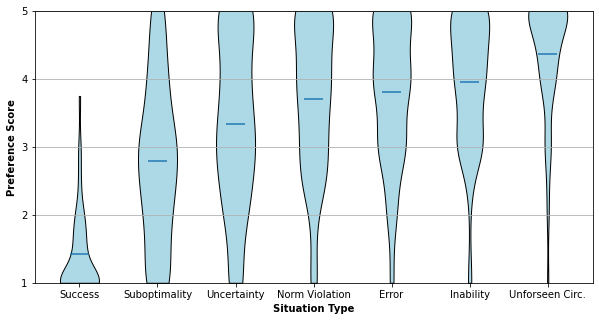

In [18]:
def get_preference_rating(preference):
    all_pref_columns=df.filter(regex='^ResponsePref').columns
    dict_pref_ratings = {}
    for sit in SITUATION_TYPES:
        dict_pref_ratings[sit] = []
    ending = PREF_MAPPING[preference]
    for sit in SITUATION_TYPES:
        print(sit)
        # get columns for that specific situation
        pref_columns_sit = [col for col in all_pref_columns if sit in col]
        # get columns for that specific pref
        pref_columns_sit_ending = [col for col in pref_columns_sit if col.endswith(ending)]
        # get mean per index/row for df[pref_columns_sit_ending]
        print(df[pref_columns_sit_ending].mean(axis=1))
        dict_pref_ratings[sit] = df[pref_columns_sit_ending].mean(axis=1).tolist()
    
    return dict_pref_ratings
            

pref_per_sit_dict=get_preference_rating("Why-Expl.")

# visualize as boxplot or violin plot with one entry per situation type
plt.figure(figsize=(10,5))
#plt.title("Preference for Why-Explanation")
plt.ylabel("Preference Score")
plt.xlabel("Situation Type")

plt.ylim(1, 5)
plt.yticks(np.arange(1, 5.5, 1))
# violinplot 
# sort dict by mean    
sorted_dict = {k: v for k, v in sorted(pref_per_sit_dict.items(), key=lambda item: np.mean(item[1]))}
# get resorted index (integer)
sorted_index = [SITUATION_TYPES.index(k) for k in sorted_dict.keys()]
# resort existing SITUATION_TYPE_LABELS based on the same index changes
sorted_labels = [SITUATION_TYPE_LABELS[i] for i in sorted_index]


vp  = plt.violinplot(sorted_dict.values(), showmeans=True, showmedians=False, showextrema=False)
for pc in vp['bodies']:
    pc.set_facecolor('lightblue')
    pc.set_edgecolor('black')
    pc.set_alpha(1)
ax = plt.gca()
ax.set_xticklabels(sorted_labels)
ax.set_xticks(np.arange(1, 8, 1))
# make x and y label bold
ax.set_xlabel(ax.get_xlabel(), fontweight='bold')
ax.set_ylabel(ax.get_ylabel(), fontweight='bold')
# grid
plt.grid(axis='y')

plt.show()

In [19]:
# compute p-value between all list combinations in the dict pref_per_sit_dict
normality_plots=False

sit_key=list(pref_per_sit_dict.keys())
for sit in sit_key:
    for sit2 in sit_key[sit_key.index(sit)+1:]:
        # test if normal
        #print(sit, sit2, stats.shapiro(pref_per_sit_dict[sit]))
        #print(sit, sit2, stats.shapiro(pref_per_sit_dict[sit2]))
        if sit=="Suc":
            alternative="less"
        else:
            alternative="two-sided"
        # Statistical Test for Normality with Shapiro-Wilk Test
        differences = np.array(pref_per_sit_dict[sit]) - np.array(pref_per_sit_dict[sit2])
        shapiro_test = stats.shapiro(differences)
        if normality_plots:
            plt.hist(differences, bins=20, alpha=0.7, color='g')
            plt.title('Histogram of Differences')
            plt.xlabel('Difference Score')
            plt.ylabel('Frequency')
            plt.show()
            stats.probplot(differences, dist="norm", plot=plt)
            plt.title('Q-Q Plot of Differences')
            plt.show()
            print(f"Shapiro-Wilk Test Statistic: {shapiro_test[0]}, p-value: {shapiro_test[1]}")
        # test
        if shapiro_test[1] < 0.05:
            #test_res = stats.wilcoxon(pref_per_sit_dict[sit], pref_per_sit_dict[sit2], alternative=alternative) 
            test_res = pg.wilcoxon(pref_per_sit_dict[sit], pref_per_sit_dict[sit2], alternative=alternative)
            #print(test_res)
            p_value = test_res["p-val"].values[0]
            effect_size = test_res["CLES"].values[0]
        else:
            test_res = stats.ttest_rel(pref_per_sit_dict[sit], pref_per_sit_dict[sit2], alternative=alternative)
            p_value = test_res[1]
            effect_size = cohen_d(pref_per_sit_dict[sit], pref_per_sit_dict[sit2])
        all_p_values.append(p_value)
        label = "ExplanationNeed_"+sit+"_vs_"+sit2
        p_value_labels.append(label)
        if p_value < 0.01:
            print(sit, sit2, p_value, effect_size, "***")
        elif p_value < 0.05:
            print(sit, sit2, p_value, effect_size, "**")
        elif p_value < 0.1:
            print(sit, sit2, p_value, effect_size, "*")
        else:
            print(sit, sit2, p_value, effect_size)

        # get effect size
        print("  Effect Size: ", effect_size)
        all_effect_sizes.append(effect_size)

Suc Err 1.4182038732779527e-31 0.9582321655682737 ***
  Effect Size:  0.9582321655682737
Suc Unc 1.4510526929917506e-29 0.9008122326280494 ***
  Effect Size:  0.9008122326280494
Suc Ina 1.2353098501018693e-31 0.9665712799167534 ***
  Effect Size:  0.9665712799167534
Suc Sub 2.8857861823030857e-26 0.8363394612093884 ***
  Effect Size:  0.8363394612093884
Suc Norm 6.27850718054825e-31 0.9428835703549543 ***
  Effect Size:  0.9428835703549543
Suc Unfor 4.60826587880746e-32 0.9802722858133889 ***
  Effect Size:  0.9802722858133889
Err Unc 6.808764988023587e-07 0.6072956411145797 ***
  Effect Size:  0.6072956411145797
Err Ina 0.061668994810403555 0.46210544571626777 *
  Effect Size:  0.46210544571626777
Err Sub 3.7447809886012384e-20 0.7394496473580761 ***
  Effect Size:  0.7394496473580761
Err Norm 0.20760818199770892 0.5234853740316799
  Effect Size:  0.5234853740316799
Err Unfor 7.97034885339723e-11 0.3342727482946005 ***
  Effect Size:  0.3342727482946005
Unc Ina 2.675940397295284e-10 0

In [20]:
H, p_value = stats.kruskal(*pref_per_sit_dict.values())

all_p_values.append(p_value)
p_value_labels.append("ExplanationNeed_Kruskal")
all_effect_sizes.append("NA")


print('Kruskal-Wallis H-test result:')
print('H-statistic:', H)
print('P-value:', p_value)

Kruskal-Wallis H-test result:
H-statistic: 519.9350838374858
P-value: 4.262657527830886e-109


### How do the response needs correlate with the type of person?

In [21]:
print("Mean age: " + str(pd.to_numeric(df["Age"], errors='coerce').mean()), "Min age: " + str(pd.to_numeric(df["Age"], errors='coerce').min()), "Max age: " + str(pd.to_numeric(df["Age"], errors='coerce').max()))
print("Age st dev: " + str(pd.to_numeric(df["Age"], errors='coerce').std()))
print()
print(df["Gender"].value_counts())
print()
print(df["Ethnicity"].value_counts())
print()
print(df["RobotExpScale"].describe())
print()
print(df["StudySubject"].value_counts())
print()
print(df["RobotProgramming"].value_counts())
print()
print(df["InteractionExp"].value_counts())
print()
print(df["CountryText"].value_counts())
# sum of all values in the column
print()
print(df["CountryText"].value_counts().sum())

Mean age: 37.648648648648646 Min age: 20.0 Max age: 75.0
Age st dev: 13.078392851454197

Gender
Female    97
Male      89
Name: count, dtype: int64

Ethnicity
White                                                                          130
Asian (Indian, Pakistani, Bangladeshi, Chinese, any other Asian background)     26
Black/African/Caribbean                                                         14
Mixed two or more ethnic groups                                                  7
Other (Arab or any others)                                                       6
Prefer not to say                                                                3
Name: count, dtype: int64

count    185.000000
mean       2.097297
std        1.247277
min        1.000000
25%        1.000000
50%        2.000000
75%        3.000000
max        7.000000
Name: RobotExpScale, dtype: float64

StudySubject
No     160
Yes     26
Name: count, dtype: int64

RobotProgramming
No     179
Yes      7
Name: count, dtype

In [22]:
# add new column to df that is avg of : AttitudesP1 to AttitudesP5
df['AttitudesAvgP'] = df[['AttitudesP1', 'AttitudesP2', 'AttitudesP3', 'AttitudesP4', 'AttitudesP5']].mean(axis=1)
df['AttitudesAvgS'] = df[['AttitudesS1', 'AttitudesS2', 'AttitudesS3', 'AttitudesS4', 'AttitudesS5']].mean(axis=1)

print(df['AttitudesAvgP'])
print(df['AttitudesAvgS'])

2      5.2
3      4.4
5      4.4
6      6.0
7      4.4
      ... 
192    1.6
193    5.0
194    7.0
195    2.8
196    5.2
Name: AttitudesAvgP, Length: 186, dtype: float64
2      6.6
3      6.0
5      6.0
6      7.0
7      5.8
      ... 
192    3.2
193    5.6
194    7.0
195    3.0
196    5.2
Name: AttitudesAvgS, Length: 186, dtype: float64


100


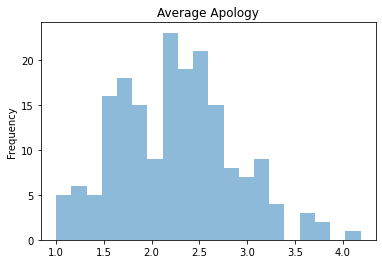

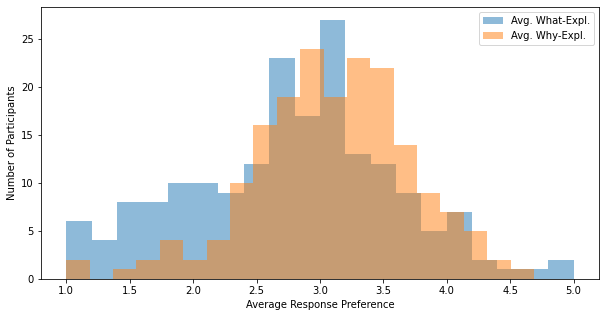

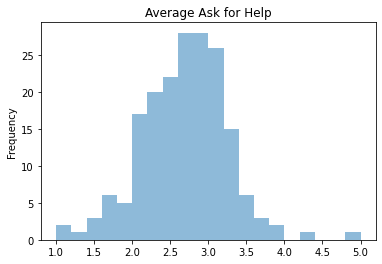

<AxesSubplot:title={'center':'Average Nothing'}, ylabel='Frequency'>

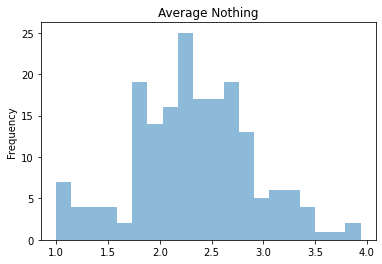

In [23]:
# print all columns of df that start with "ResponsePref"
print(len(df.filter(regex='^ResponsePref').columns))
# PREF_MAPPING = {"Apology": "1", "Why-Expl.":"2", "What-Expl.":"3", "Next-Action":"4", "Ask-for-Help":"5", "Continue":"6"}          


# add avg_apology column, etc.
df['avg_apology'] = df.filter(regex='^ResponsePref.*_1$').mean(axis=1)
df['avg_why_explain'] = df.filter(regex='^ResponsePref.*_2$').mean(axis=1)
df['avg_what_explain'] = df.filter(regex='^ResponsePref.*_3$').mean(axis=1)
df['avg_future_action'] = df.filter(regex='^ResponsePref.*_4$').mean(axis=1)
df['avg_ask_for_help'] = df.filter(regex='^ResponsePref.*_5$').mean(axis=1)
df['avg_nothing'] = df.filter(regex='^ResponsePref.*_6$').mean(axis=1)


# plot histograms of averages
df['avg_apology'].plot(kind='hist', bins=20, title='Average Apology', alpha=0.5)
plt.show()
#df['avg_future_action'].plot(kind='hist', bins=20, alpha=0.5)
df['avg_what_explain'].plot(kind='hist', bins=20, alpha=0.5, figsize=(10,5))
df['avg_why_explain'].plot(kind='hist', bins=20, alpha=0.5)
# add legend
plt.legend(['Avg. What-Expl.','Avg. Why-Expl.'])
# x-axis label
plt.xlabel('Average Response Preference')
# y-axis label
plt.ylabel('Number of Participants')
plt.show()
df['avg_ask_for_help'].plot(kind='hist', bins=20, title='Average Ask for Help', alpha=0.5)
plt.show()
df['avg_nothing'].plot(kind='hist', bins=20, title='Average Nothing', alpha=0.5)





Correlations between attitudes towards robots(Personal Level) and:
avg_apology SpearmanrResult(correlation=0.14711236344156012, pvalue=0.045098439394571296)
avg_why_explain SpearmanrResult(correlation=0.05577742782161405, pvalue=0.44955118293141594)
avg_what_explain SpearmanrResult(correlation=0.03476330503922687, pvalue=0.6376017555455964)
avg_future_action SpearmanrResult(correlation=0.023168534278776454, pvalue=0.7536055519439631)
avg_ask_for_help SpearmanrResult(correlation=-0.12196168251342149, pvalue=0.09725309283368247)
avg_nothing SpearmanrResult(correlation=0.02877046468641777, pvalue=0.6966752675969992)

Correlations between attitudes towards robots(Societal Level) and:
avg_apology SpearmanrResult(correlation=0.07252450348387067, pvalue=0.3252479730619421)
avg_why_explain SpearmanrResult(correlation=0.0962317693708832, pvalue=0.19134402751422783)
avg_what_explain SpearmanrResult(correlation=-0.0020616221465277864, pvalue=0.9777201642925781)
avg_future_action SpearmanrResult(c

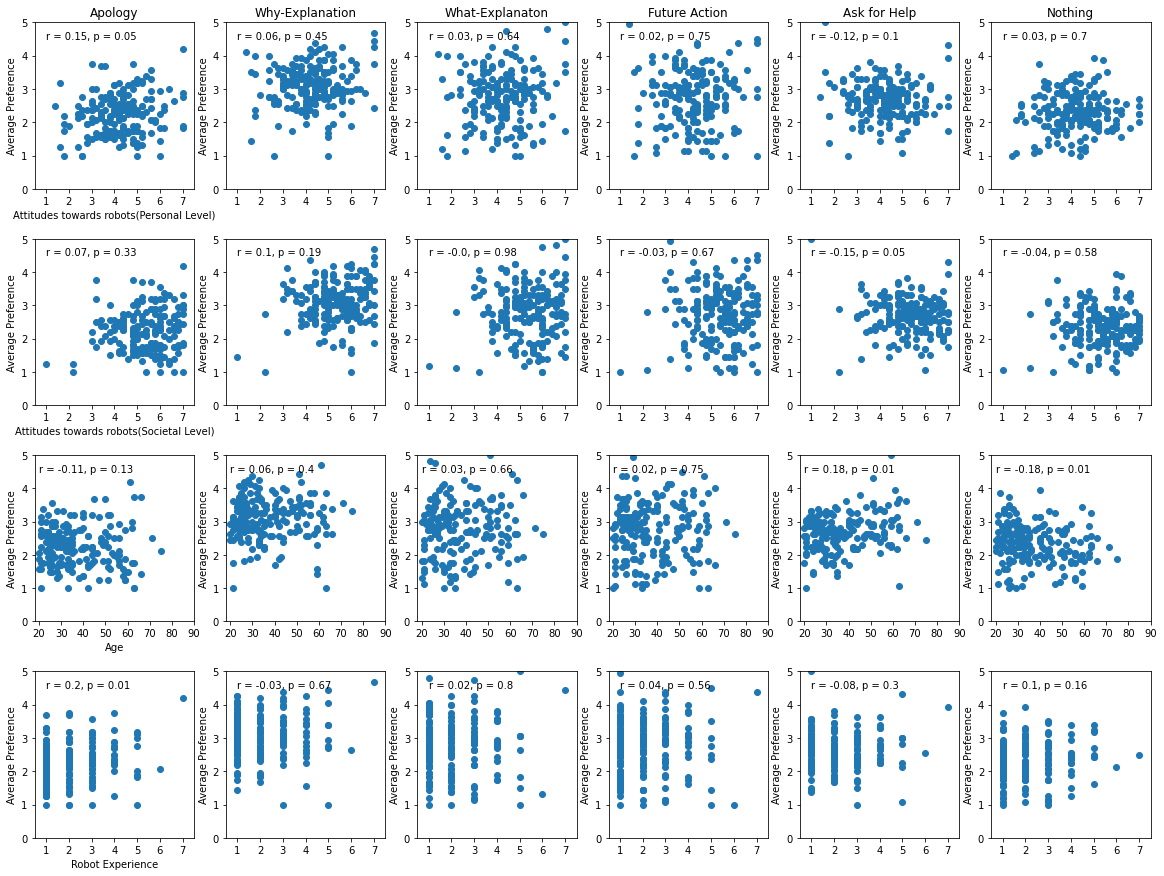

In [24]:
print('Correlations between attitudes towards robots(Personal Level) and:')
for col in ['avg_apology', 'avg_why_explain', 'avg_what_explain', 'avg_future_action', 'avg_ask_for_help', 'avg_nothing']:
    print(col, spearmanr(df['AttitudesAvgP'], df[col]))
    p_value = spearmanr(df['AttitudesAvgP'], df[col])[1]
    all_p_values.append(p_value)
    label = "correlation_" + col+"_attitudesAvgPersonal"
    p_value_labels.append(label)
    all_effect_sizes.append(spearmanr(df['AttitudesAvgP'], df[col])[0])
    

print('\nCorrelations between attitudes towards robots(Societal Level) and:')
for col in ['avg_apology', 'avg_why_explain', 'avg_what_explain', 'avg_future_action', 'avg_ask_for_help', 'avg_nothing']:
    print(col, spearmanr(df['AttitudesAvgS'], df[col]))
    p_value = spearmanr(df['AttitudesAvgS'], df[col])[1]
    all_p_values.append(p_value)
    label = "correlation_" + col+"_attitudesAvgSocietal"
    p_value_labels.append(label)
    all_effect_sizes.append(spearmanr(df['AttitudesAvgS'], df[col])[0])

print('\nCorrelations between age and:')
for col in ['avg_apology', 'avg_why_explain', 'avg_what_explain', 'avg_future_action', 'avg_ask_for_help', 'avg_nothing']:
    age_no_nans= df['Age'].replace('Prefer not to say', np.nan).dropna().astype(int)
    col_no_nans = []
    for index, row in df.iterrows():
        if index in age_no_nans.index:
            col_no_nans.append(row[col])
    print(col, spearmanr(age_no_nans, col_no_nans))
    p_value = spearmanr(age_no_nans, col_no_nans)[1]
    all_p_values.append(p_value)
    label = "correlation_" + col+"_age"
    p_value_labels.append(label)
    all_effect_sizes.append(spearmanr(age_no_nans, col_no_nans)[0])
    
print('\nCorrelations between robot experience and:')
for col in ['avg_apology', 'avg_why_explain', 'avg_what_explain', 'avg_future_action', 'avg_ask_for_help', 'avg_nothing']:
    print(col, spearmanr(df['RobotExpScale'], df[col], nan_policy="omit"))
    robot_exp_no_nans= df['RobotExpScale'].dropna()
    p_value = spearmanr(df['RobotExpScale'], df[col], nan_policy="omit")[1]
    all_p_values.append(p_value)
    label = "correlation_" + col+"_robotExp"
    p_value_labels.append(label)
    all_effect_sizes.append(spearmanr(df['RobotExpScale'], df[col], nan_policy="omit")[0])

#  visualize correlations as scatter plots (4x5)
fig, axes = plt.subplots(4, 6, figsize=(20, 15))
col_tiltes=['Apology', 'Why-Explanation', 'What-Explanaton','Future Action', 'Ask for Help', 'Nothing']
for i, col in enumerate(['avg_apology', 'avg_why_explain', 'avg_what_explain', 'avg_future_action', 'avg_ask_for_help', 'avg_nothing']):
    axes[0, i].scatter(df['AttitudesAvgP'], df[col])
    axes[0, i].set_title(col_tiltes[i])
    axes[1, i].scatter(df['AttitudesAvgS'], df[col])
    # age can have nan values, so we need to drop them and adapt the other columns accordingly
    age_to_plot = df['Age'].replace('Prefer not to say', np.nan).dropna().astype(int)
    # drop rows in df[col] where same index has nan in df["Age"]
    col_to_plot = []
    for index, row in df.iterrows():
        if index in age_to_plot.index:
            col_to_plot.append(row[col])
    axes[2, i].scatter(age_to_plot, col_to_plot)
    axes[3, i].scatter(df['RobotExpScale'], df[col])
    # set y axis limits
    axes[0, i].set_ylim(0, 5)
    axes[1, i].set_ylim(0, 5)
    axes[2, i].set_ylim(0, 5)
    axes[3, i].set_ylim(0, 5)
    # set x axis limits
    axes[0, i].set_xlim(0.5, 7.5)
    axes[1, i].set_xlim(0.5, 7.5)
    axes[2, i].set_xlim(18, 90)
    axes[3, i].set_xlim(0.5, 7.5)
    # set x ticks
    axes[0, i].set_xticks([1, 2, 3, 4, 5, 6, 7])
    axes[1, i].set_xticks([1, 2, 3, 4, 5, 6, 7])
    axes[2, i].set_xticks([20, 30, 40, 50, 60, 70, 80, 90])
    axes[3, i].set_xticks([1, 2, 3, 4, 5, 6, 7])
    # set y label
    axes[0, i].set_ylabel('Average Preference')
    axes[1, i].set_ylabel('Average Preference')
    axes[2, i].set_ylabel('Average Preference')
    axes[3, i].set_ylabel('Average Preference')
    # set x label
    if i == 0:
        axes[0, i].set_xlabel('Attitudes towards robots(Personal Level)')
        axes[1, i].set_xlabel('Attitudes towards robots(Societal Level)')
        axes[2, i].set_xlabel('Age')
        axes[3, i].set_xlabel('Robot Experience')
    # add correlation coefficient
    axes[0, i].text(1, 4.5, 'r = ' + str(round(spearmanr(df['AttitudesAvgP'], df[col])[0], 2))+', p = ' + str(round(spearmanr(df['AttitudesAvgP'], df[col])[1], 2)))
    axes[1, i].text(1, 4.5, 'r = ' + str(round(spearmanr(df['AttitudesAvgS'], df[col])[0], 2))+', p = ' + str(round(spearmanr(df['AttitudesAvgS'], df[col])[1], 2)))
    axes[2, i].text(20, 4.5, 'r = ' + str(round(spearmanr(age_to_plot, col_to_plot, nan_policy="omit")[0], 2))+', p = ' + str(round(spearmanr(age_to_plot, col_to_plot)[1], 2)))
    axes[3, i].text(1, 4.5, 'r = ' + str(round(spearmanr(df['RobotExpScale'], df[col], nan_policy="omit")[0], 2))+', p = ' + str(round(spearmanr(df['RobotExpScale'], df[col], nan_policy="omit")[1], 2)))
    # increase space between rows 
    plt.subplots_adjust(hspace=0.3)
plt.show()


In [25]:
# for gender we do t-tests 

for col in ['avg_apology', 'avg_why_explain', 'avg_what_explain', 'avg_future_action', 'avg_ask_for_help', 'avg_nothing']:
    # get the rows where "Gender" is "Male"/"Female" and add to respective lists
    male_scores = []
    female_scores = []
    for i in range(len(df)):
        if (df.iloc[i]["Gender"] == "Male"):
            male_scores.append(df.iloc[i][col])
        elif (df.iloc[i]["Gender"] == "Female"):
            female_scores.append(df.iloc[i][col])
    # test for normality
    shapiro_test_1 = stats.shapiro(male_scores)
    shapiro_test_2 = stats.shapiro(female_scores)
    # run test
    print(col)
    if shapiro_test[1] < 0.05  or shapiro_test[1] < 0.05:
        # wilcoxon
        print(f"Non normal")
        #print("   ", stats.ranksums(male_scores, female_scores))
        #p_val = stats.ranksums(male_scores, female_scores)[1]
        tes_res = pg.mwu(male_scores, female_scores)
        p_val = tes_res['p-val'].values[0]
        effect_size = tes_res["CLES"].values[0]
        print(test_res)
    else:
        print("   ", stats.ttest_ind(male_scores, female_scores))
        p_val = stats.ttest_ind(male_scores, female_scores)[1]
        effect_size = cohen_d(male_scores, female_scores)
    all_p_values.append(p_val)
    label="GenderDif_"+col
    p_value_labels.append(label)
    print("    male avg:", round(sum(male_scores)/len(male_scores),2), "female avg:", round(sum(female_scores)/len(female_scores),2))
    print("   ", cohen_d(male_scores, female_scores))
    all_effect_sizes.append(effect_size)


avg_apology
Non normal
           W-val alternative         p-val      RBC      CLES
Wilcoxon  1335.0   two-sided  5.864690e-13 -0.70915  0.319401
    male avg: 2.29 female avg: 2.21
    0.13788875310934606
avg_why_explain
Non normal
           W-val alternative         p-val      RBC      CLES
Wilcoxon  1335.0   two-sided  5.864690e-13 -0.70915  0.319401
    male avg: 3.14 female avg: 3.06
    0.11616799151754066
avg_what_explain
Non normal
           W-val alternative         p-val      RBC      CLES
Wilcoxon  1335.0   two-sided  5.864690e-13 -0.70915  0.319401
    male avg: 2.78 female avg: 2.77
    0.012587106066845186
avg_future_action
Non normal
           W-val alternative         p-val      RBC      CLES
Wilcoxon  1335.0   two-sided  5.864690e-13 -0.70915  0.319401
    male avg: 2.74 female avg: 2.73
    0.011933855724094783
avg_ask_for_help
Non normal
           W-val alternative         p-val      RBC      CLES
Wilcoxon  1335.0   two-sided  5.864690e-13 -0.70915  0.319401
   

## Multiple Corrections

In [26]:
print(len(all_p_values), len(p_value_labels), len(all_effect_sizes))
holm_correction = statsmodels.stats.multitest.multipletests(all_p_values, alpha=0.05, method='holm', is_sorted=False, returnsorted=False)
counter = 0
significant_results = []
for i in range(len(all_p_values)):
    if holm_correction[0][i] == True:
        print(p_value_labels[i], all_p_values[i], holm_correction[1][i], all_effect_sizes[i])
        significant_results.append(p_value_labels[i])
        counter += 1
print(counter)

157 157 157
Suc_Apology_Why-Expl. 2.1560818996287184e-09 1.617061424721539e-07 0.37825182101977106
Suc_Apology_What-Expl. 3.2942829084545872e-12 2.8001404721863993e-10 0.34878309631171234
Suc_Apology_Next-Action 8.662795244214404e-18 8.57616729177226e-16 0.28438258758237944
Suc_Apology_Continue 8.395085694403278e-31 1.2592628541604918e-28 0.03981674181986357
Suc_Why-Expl._What-Expl. 0.0009319396263170488 0.04659698131585244 0.46092033761128454
Suc_Why-Expl._Next-Action 3.605612443642105e-08 2.4518164616766314e-06 0.3973436235402937
Suc_Why-Expl._Ask-for-Help 1.6369830629884493e-05 0.0009330803459034161 0.5777546537171927
Suc_Why-Expl._Continue 1.0969330544599942e-29 1.6015222595115916e-27 0.06808590588507342
Suc_What-Expl._Ask-for-Help 3.221774812193949e-10 2.4807666053893407e-08 0.610619724823679
Suc_What-Expl._Continue 1.4466122875738985e-26 1.938460465349024e-24 0.09287200832466182
Suc_Next-Action_Ask-for-Help 8.42011226185161e-15 7.830704403521998e-13 0.673618337380044
Suc_Next-Act

## Qualitative Comments

In [867]:
# get all columns with qual in the name
columns_qual = [i for i in df.columns if "Qual" in i]
print(columns_qual)
for col in columns_qual:
    print(col)
    # itterate over df[col]
    for i in df[col]:
        # check for nan
        if i == i:
            print("   ",i,"\n")

['Qual_Unc_L', 'Qual_Unc_P', 'Qual_Err_G', 'Qual_Err_S', 'Qual_Sub_G', 'Qual_Suc_T', 'Qual_Suc_G', 'Qual_Suc_J', 'Qual_Suc_V', 'Qual_Ina_G', 'Qual_Ina_B', 'Qual_Sub_M', 'Qual_Norm_C', 'Qual_Norm_M', 'Qual_Unfor_P', 'Qual_Unfor_O', 'QualComFinal']
Qual_Unc_L
    Ask for information to help it perform the task. 

    The robot is correct and should ask user to clarify where the coke has been left.  

    The robot should check both areas if it is unsure and see if it is in either location.
The robot should notify the person if the object cannot be found in either room.
The robot should ask if the person has any other ideas of where it might be, so that the robot could check further. 

    Robot needs clearer instructions as to where coke bottle is 

    The robot should ask where the coke is  

    The robot could ask where the coke bottle is, rather than saying it is not sure which room it is in. 

    They could offer reassurance that they’ll retrieve the coke once they know it’s locat

 

    No. 

    Ask for directions. 

    covered above 

    Good question from the robot 

    Human was not specific enough with tasks/questions, Human should be re-trained when assigning tasks to robot .Robots incomplete action should logged and sent to controller for analysis. 

    the robot should say that it is unable to know if a cake has risen or not 

    yeah, I would want the robot to just go do what I asked , 

Qual_Err_G
    no, just pick it up like mentioned 

    Tell the human that they really don't need a robot to perform that task. 

    '- the robot has no emotion , cannot ask for help or apologise for what it does 

    none 

    The robot needs to be able to pick things up quicker. 

    Attempt to pick the black tea up from the floor. 

    They could educate the person on how this could be avoided in the future.  

    The robot should ensure it contacts the perosn who made the request with a 'fail' notification. 

    To explain that it cannot get the black 